In [196]:
"""
SELECT players.username, team, level_index, play_id, actions
  FROM players
  JOIN playthroughs ON players.username=playthroughs.username
  INTO OUTFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/times.txt';
"""

"\nSELECT players.username, team, level_index, play_id, actions\n  FROM players\n  JOIN playthroughs ON players.username=playthroughs.username\n  INTO OUTFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/times.txt';\n"

In [269]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [270]:
rows = []
rx = re.compile('([0-9]+)[^;\n]+[;|\n]')
with open('times.txt') as f:
    for line in f:
        name,team,lid,pid,actions = line.split('\t')
        team = int(team)
        lid = int(lid)
        pid = int(pid)
        
        total_time = 0
        n_actions = 0
        for match in rx.finditer(actions):
            total_time += int(match.group(1))
            n_actions += 1
        rows.append([name, team, lid, pid, total_time, n_actions])
        
df = pd.DataFrame(rows, columns=['name','team','lid','pid','time','n_acts'])
df.head()

,name,team,lid,pid,time,n_acts
0,135Mallos,0,1,8144,639,7
1,135Mallos,0,2,8146,160,14
2,135Mallos,0,3,8148,168,7
3,135Mallos,0,4,8149,82,10
4,135Mallos,0,5,8152,229,23


In [271]:
print(len(df))

9837


In [272]:
def bs_permute(dist1, dist2, func, size):
    distboth = np.concatenate((dist1,dist2))
    
    bs_samples = np.empty(size)
    for i in range(size):
        scrambled = np.random.permutation(distboth)
        perm1 = scrambled[:len(dist1)]
        perm2 = scrambled[len(dist1):]
        bs_samples[i] = func(perm1, perm2)
        
    return bs_samples

def diff_meds(dist1, dist2):
    return np.median(dist1) - np.median(dist2)
    
def test_median(dist1, dist2, size):
    gtruth_dmed = diff_meds(dist1, dist2)
    sample_dmeds = bs_permute(dist1, dist2, diff_meds, size)
    
    pval = np.sum(sample_dmeds >= gtruth_dmed) / len(sample_dmeds)
    return pval

In [274]:
lid_grouped = df.groupby('lid')

teams0 = {}
teams1 = {}
pvals0 = {}
pvals1 = {}
for lid in lid_grouped.groups.keys():
    df_lid = lid_grouped.get_group(lid)
    df_pid = df_lid.sort_values('pid').drop_duplicates('name') # only take first playthrough
    
    # separate teams
    team_group = df_pid.groupby('team')
    team0 = team_group.get_group(0)['time']
    team1 = team_group.get_group(1)['time']
    teams0[lid] = team0
    teams1[lid] = team1
    
    pval0 = test_median(team0, team1, 100000)
    pval1 = test_median(team1, team0, 100000)
    pvals0[lid] = pval0
    pvals1[lid] = pval1
    
    print(f'{lid} p0={pval0} p1={pval1}')
    
    # TODO
#     if lid>100:
    

1 p0=0.71405 p1=0.29208
2 p0=0.74389 p1=0.27132
3 p0=0.76994 p1=0.25151
4 p0=0.90862 p1=0.11835
5 p0=0.49555 p1=0.53375
6 p0=0.73978 p1=0.26119
7 p0=0.06088 p1=0.95972
8 p0=0.9234 p1=0.08209
9 p0=0.99162 p1=0.00797
10 p0=0.89016 p1=0.10992
11 p0=0.82214 p1=0.17937
12 p0=0.99874 p1=0.00127
13 p0=0.41914 p1=0.58866
14 p0=0.9363 p1=0.06679
15 p0=0.40587 p1=0.59513
16 p0=0.9163 p1=0.08823
17 p0=0.81985 p1=0.18076
18 p0=0.31458 p1=0.68862
101 p0=0.71567 p1=0.2816
102 p0=0.63819 p1=0.36083
103 p0=0.6816 p1=0.31978


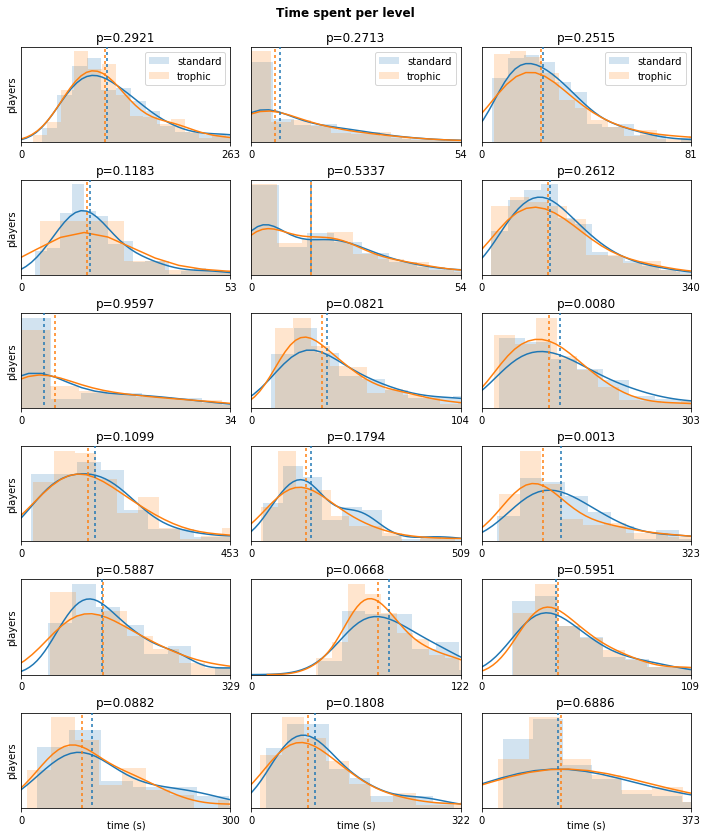

In [275]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12,14))
plt.subplots_adjust(wspace=.1, hspace=.4)
cmap = plt.get_cmap('tab10')

for lid in teams0.keys():
    # choose axis
    i = lid-1
    if i>=100:
        continue
    
    team0 = teams0[lid]
    team1 = teams1[lid]
    pval1 = pvals1[lid]
    
    ax = axes[(i//3,i%3)]
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    
    conf0 = np.percentile(team0, [0,50,95])
#     conf1 = np.percentile(team1, [2.5,97.5])
    ax.set_xlim([0,conf0[2]])
    ax.set_xticks([0,conf0[2]])
    ax.set_xticklabels([0,int(conf0[2]/10)])
    
    sns.distplot(team1, ax=ax, hist_kws=dict(alpha=.2))
    sns.distplot(team0, ax=ax, hist_kws=dict(alpha=.2))

    if lid<=3:
        ax.legend(['standard','trophic'])
    
    med0 = np.median(team0)
    med1 = np.median(team1)
    
    ax.axvline(med0, color=cmap(.1), ls=(0,[2,2]), zorder=10)
    ax.axvline(med1, color=cmap(0), ls=(2,[2,2]), zorder=10)
    
    ax.set_title(f'p={pval1:.4f}')
    ax.set_xlabel(' ')
    
for i in range(6):
    axes[i,0].set_ylabel('players')
for i in range(3):
    axes[5,i].set_xlabel('time (s)', labelpad=-5)

fig.suptitle(r'Time spent per level', fontweight='bold', y=.92)
plt.savefig('results/times.pdf', bbox_inches='tight')

In [243]:
# extract total time

grouped = df.groupby('name')
times = grouped['time'].sum()
teams = grouped['team'].first()
# progress = grouped['lid'].max()
# acts = grouped['n_acts'].sum()

times0 = []
times1 = []
# progress0 = []
# progress1 = []
for name in times.keys():
    if teams[name] == 0:
        times0.append(times[name])
#         progress0.append(progress[name])
    else:
        times1.append(times[name])
#         progress1.append(progress[name])

In [244]:
times_pval = test_median(times0, times1, 10000)
# stars_pval = test_median(stars0, stars1, 10000)
print(f'tp={times_pval}')

tp=0.0732


Text(0.5, 1.0, 'p = 0.0732')

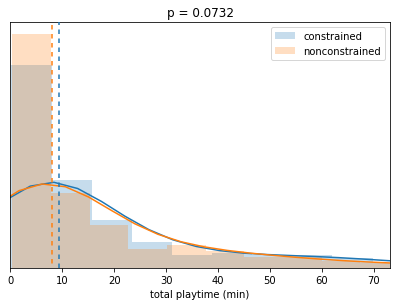

In [245]:
# plot histogram

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
fig.tight_layout()

# hists
sns.distplot(times0, hist_kws=dict(alpha=.25), ax=ax)
sns.distplot(times1, hist_kws=dict(alpha=.25), ax=ax)

ax.legend(['constrained','nonconstrained'])
ax.set_xlabel('total playtime (min)')

# medians
cmap = plt.get_cmap('tab10')
tmed0 = np.median(times0)
tmed1 = np.median(times1)
ax.axvline(tmed0, color=cmap(0), ls=(0,[3,3]), zorder=10)
ax.axvline(tmed1, color=cmap(.1), ls=(3,[3,3]), zorder=10)


# ticks
ax.tick_params(axis='y', which='both', left=False, labelleft=False)

conf0 = np.percentile(times0, [0,50,95])
ax.set_xlim([0,conf0[2]])

xticks = list(range(0,42001,6000))
ax.set_xticks(xticks)
xticklabels = [int(tick/600) for tick in xticks]
ax.set_xticklabels(xticklabels)

ax.set_title(f'p = {times_pval}')